# Import Telemetry class


In [5]:
from TMclass import *
import datetime
fromiso = datetime.datetime.fromisoformat
tdelta = datetime.timedelta
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xml.etree import ElementTree
import os

def flush_many(max_vol, vol_dataset, phi_mode, start, nbits, ndata, level, partition):
    global PHI
    global phi

    def _new_start(start,end):
        start += datetime.timedelta(days=1)
        start = start.replace(hour=3,minute=0,second=0)
        if end > start:
            start = end + datetime.timedelta(hours=1)
        return start
    

    vol0 = max_vol[0]
    vol1 = max_vol[1]
    n0 = int(vol0 // vol_dataset * 0.99)
    n1 = int(vol1 // vol_dataset * 0.99)

    if ndata == -1:
        ndata = phi_mode.raw.n_datasets
    
    print(f'Days needed: {(ndata-n0)//n1+2}')
    kw = phi_mode.compressing(start, nbits = nbits, ndata = n0,level=level); phi.saving(partition,**kw); PHI.saving(partition,**kw)
    # start += datetime.timedelta(days=1)
    start = _new_start(start,kw['end'])

    for i in range((ndata-n0)//n1+1):
        kw = phi_mode.compressing(start, nbits = nbits, ndata = n1,level=level); phi.saving(partition,**kw); PHI.saving(partition,**kw)
        start = _new_start(start,kw['end'])

    return (phi_mode, kw)

PHI = PHI_MEMORY(datetime.datetime.fromisoformat('2022-01-19T23:00:00'))

TM = {'date':[], 'tm_rate':[], 'duration':[]}
TMnew = {'date':[], 'tm_rate':[], 'duration':[]}

with open('../telem.xml') as f:
    tree = ElementTree.parse(f)

for node in tree.iter('PASS'):
    d = datetime.datetime.fromisoformat(node.attrib.get('comment')[:-1]).date()
    if d >= datetime.date(2022,1,1) and d <= datetime.date(2023,1,1):
        TM['date'] += [datetime.datetime.fromisoformat(node.attrib.get('comment')[:-1])]
        TM['tm_rate'] += [float(node.attrib.get('tm_rate'))]
        TM['duration'] += [int(node.attrib.get('duration'))]

with open('../EFECS_M06_V00.xml') as f:
    tree = ElementTree.parse(f)

for node in tree.iter('PASS'):
    d = datetime.datetime.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S").date()
    if d >= datetime.date(2022,1,1) and d <= datetime.date(2023,1,1):
        TMnew['date'] += [datetime.datetime.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S")]
        TMnew['tm_rate'] += [float(node.attrib.get('tm_rate'))]
        TMnew['duration'] += [int(node.attrib.get('duration'))]

TM['date'] = np.asarray(TM['date'])
TM['tm_rate'] = np.asarray(TM['tm_rate'])
TM['duration'] = np.asarray(TM['duration'])

TMnew['date'] = np.asarray(TMnew['date'])
TMnew['tm_rate'] = np.asarray(TMnew['tm_rate'])
TMnew['duration'] = np.asarray(TMnew['duration'])

f = open('phi.itl','r')
lines = f.readlines()

FL = {'date':[], 'flush':[]}

for x in lines:
    temp = x.split(' ')
    if 'PHI_SCI_Flush_VOL' in temp[-1]:
        FL['date'] += [datetime.datetime.fromisoformat(temp[0][:-1])]
        FL['flush'] += [float(temp[-1][19:-2])]
        # print(temp[0][:-1],temp[-1][19:-2])

FL['date'] = np.asarray(FL['date'])
FL['flush'] = np.asarray(FL['flush'])

f = open('phi.itl','r')
lines = f.readlines()

# SV = {'date':[], 'rate':[]}

# for x in lines:
#     temp = x.split(' ')
#     if 'PHI_SCI_Rate' in temp[-1]:
#         SV['date'] += [datetime.datetime.fromisoformat(temp[0][:-1])]
#         SV['rate'] += [float(temp[-1][14:-2])]
#         # print(temp[0][:-1],temp[-1][19:-2])

# SV['date'] = np.asarray(SV['date'])
# SV['rate'] = np.asarray(SV['rate'])

f = open('phi_new.itl','r')
lines = f.readlines()

FLnew = {'date':[], 'flush':[]}

for x in lines:
    temp = x.split(' ')
    if 'PHI_SCI_Flush_VOL' in temp[-1]:
        FLnew['date'] += [datetime.datetime.fromisoformat(temp[0][:-1])]
        FLnew['flush'] += [float(temp[-1][19:-2])]
        # print(temp[0][:-1],temp[-1][19:-2])

FLnew['date'] = np.asarray(FLnew['date'])
FLnew['flush'] = np.asarray(FLnew['flush'])



Leggo il csv come (t,fcp,id), in cui id ha un certo numero di entrate. Creo PHI dal primo orario - 1 giorno o lo creo a mano

In [6]:
PHI = PHI_MEMORY(fromiso('2022-03-05T00:00:00'))

def load_csv(fname):
    import pandas as pd

    dateparse = lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S')

    dur = pd.read_csv('/home/calchetti/Desktop/phi_proc_time.lst')

    cols = ['start','fcp']
    for i in range(35):
        cols.append('FP_'+str(i+1))

    df = pd.read_csv(fname, names=cols, keep_default_na=False, index_col=False, parse_dates=[0], date_parser=dateparse)
    # df = df[df.fcp != 'TMPGAP']
    df.insert(loc=1, column='end', value=None, allow_duplicates=True)
    df = df.query("fcp != 'TMPGAP'")
    df = df.query("fcp != 'STDGAP'")
    df = df.query("fcp != 'OBJECT'")
    df = df.query("fcp != 'SUBJECT'")
    df = df.query("fcp != 'PURPOSE'")

    old = 0
    for i in df.index:
        
        mask = np.column_stack([dur[col].str.contains(df.fcp[i], na=False) for col in dur])
        duration = dur.loc[mask.any(axis=1)].duration
        
        if duration.size>1:
            duration = duration.iloc[0]
        
        try:
            duration = float(duration)
        except:
            try:
                temp = duration.values[0]
            except:
                temp = str(duration)
            for j in range(35):
                v = df['FP_'+str(j+1)].loc[i].lstrip('0')
                try:
                    temp = temp.replace('$FP_'+str(j+1),v)
                except:
                    pass
            duration = eval(temp)

        if pd.isnull(df.start[i]):
            df.at[i,'start'] = df.end[old] + tdelta(seconds=20)
        
        if pd.isnull(df.end[i]):
            df.at[i,'end'] = df.at[i,'start'] + tdelta(seconds=duration)
        
        old = i
    
    return df


In [7]:
def levels_did_out(phi_mode):
    def find_levels(s):
        levels = []
        t = []
        
        for k, v in s.__dict__.items():
            if k in ['raw','crop','bin','pack','extr','proc','compr']:
                t += [getattr(s,k)]
                levels += [t[-1].level]
        return levels, t

    levels = []
    temp = [[]]
    temp[0] += [phi_mode]
    i = 0
    while temp[i] != []:
        i += 1
        temp += [[]]
        for t in temp[i-1]:
            l,tt = find_levels(t); levels += l; temp[i] += tt;
        
    # temp = temp[:-1]
    temp = [t for tt in temp[1:] for t in tt]
    return levels, [t.did for t in temp], [t.n_datasets for t in temp]
    
def find_consecutive(obs,did):
    did_int = int(did)
    keys = list(obs.keys()); keys = [i for i in keys if 'copy' not in i]
    start_did = np.asarray(keys,dtype=np.int)

    n_datasets = np.asarray([obs[k].raw.n_datasets for k in keys],dtype=np.int)

    cond = start_did - (did_int) + n_datasets == 0
    obs_i = np.where(cond)[0]

    if len(obs_i) == 1:
        obs_i = obs_i[0]; 
        return keys[obs_i]
    elif len(obs_i) > 1:
        print(f'more observations found with this possible consecutive DID: {did}')

def find_did(obs,did,crop = 500,end='\n'):
    keys = list(obs.keys()); keys = [i for i in keys if 'copy' not in i]
    levels = []
    dids = []
    n_datasets = []
    for i,k in enumerate(keys):
        out = levels_did_out(obs[k])
        levels += [[]]
        dids += [[]]
        n_datasets += [[]]
        levels[i] += out[0]
        dids[i] += out[1]
        n_datasets[i] += [max(out[2])]*len(out[2])
        
    all_levels = np.asarray([t for tt in levels for t in tt])
    all_dids = np.asarray([t for tt in dids for t in tt],dtype=int)
    n_datasets = np.asarray([t for tt in n_datasets for t in tt],dtype=int)
    
    # n_datasets = np.asarray([obs[k].raw.n_datasets for k in keys],dtype=np.int)
    did_int = int(did)
    
    cond1 = all_dids - (did_int) <= 0
    cond2 = all_dids - (did_int) + n_datasets > 0
    # obs_i,obs_j = np.where(cond1*cond2)
    obs_i = np.where(cond1*cond2)[0]
    if obs_i.size == 0:
        return did, None, None, False
    else:
        idx = obs_i[0]
    
    # if np.all(all_levels[obs_i] == all_levels[idx]):
    level = all_levels[idx]
    lev = level
    i = 0
    while lev != 'raw':
        i+=1
        lev = all_levels[idx-i]
    
    start_did = str(all_dids[idx-i]).rjust(10,'0')
    # endif
    lev = obs[start_did].level_out(level)
    
    return start_did,level,lev,True

def run(df,PHI,verbose=False):
    import sys
    import traceback

    obs = {}
    ysize = 2048
    xsize = 2048
    instr = 'HRT'

    for i in range(df.shape[0]):
        try:

            fcp = df.iloc[i].fcp

            # FPS window is restored only when we leave observation mode
            if fcp == 'FCP-002':#
                ysize = 2048
            if fcp == 'FCP-011':#
                ysize = 2048
            if fcp == 'FCP-032':#
                ysize = 2048
            if fcp == 'FCP-033':#
                ysize = 2048
            if fcp == 'FCP-034':#
                ysize = 2048
            if fcp == 'FCP-035':#
                ysize = 2048
            if fcp == 'FCP-036':#
                ysize = 2048
            if fcp == 'FCP-037':#
                ysize = 2048
            if fcp == 'FCP-038':#
                ysize = 2048
            if fcp == 'FCP-039':#
                ysize = 2048
            if fcp == 'FCP-040':#
                ysize = 2048
            if fcp == 'FCP-041':#
                ysize = 2048
            if fcp == 'FCP-042':#
                ysize = 2048
            if fcp == 'FCP-043':#
                ysize = 2048
            
            if fcp == 'FCP-216':#Schedule_Datasets.fcp
                if df.iloc[i+1].fcp != 'FCP-219': #to avoid low latency
                    t0 = df.iloc[i].start.to_pydatetime()
                    t1 = df.iloc[i].end.to_pydatetime()
                    n = 1
                    j = 3
                    while df.iloc[i][j] != '':
                        did = df.iloc[i][j]
                        try:
                            obs_i, level, lev, find = find_did(obs,did,end='\r')
                            if find:
                                kw = obs[obs_i].compressing(t0,ndata=n,nbits=6,level=level,verbose=verbose)
                                PHI.saving(id,**kw)
                            else:
                                print('DID to be flushed not found: '+did,'index:',i)
                        except:
                            print('DID to be flushed not found: '+did,'index:',i)
                            
                        j += 1

            if fcp == 'FCP-217':#Schedule_Consecutive_Datasets.fcp
                if df.iloc[i+1].fcp != 'FCP-219': #to avoid low latency
                    did = df.iloc[i].FP_1
                    t0 = df.iloc[i].start.to_pydatetime()
                    t1 = df.iloc[i].end.to_pydatetime()
                    n = int(df.iloc[i].FP_2)
                    obs_i, level, lev, find = find_did(obs,did,end='\r')
                    if find:
                        kw = obs[obs_i].compressing(t0,ndata=n,nbits=6,level=level,verbose=verbose)
                        PHI.saving(id,**kw)
                    else:
                        print('DID to be flushed not found: '+did,'index:',i)

            if fcp == 'FCP-401':#Prepare_FDT.fcp
                instr = 'FDT'
            
            if fcp == 'FCP-402':#Prepare_HRT.fcp
                instr = 'HRT'
            
            if fcp == 'FCP-405':#Set_Context_for_MTL_Reentry.fcp
                nout = {'HRT':5, 'FDT':5}
                if int(df.iloc[i].FP_13) < 30:
                    nout['HRT'] = 5
                elif int(df.iloc[i].FP_13) >= 30 and int(df.iloc[i].FP_13) < 40:
                    nout['HRT'] = 3
                else:
                    nout['HRT'] = 2
                
                if int(df.iloc[i].FP_27) < 30:
                    nout['FDT'] = 5
                elif int(df.iloc[i].FP_27) >= 30 and int(df.iloc[i].FP_27) < 40:
                    nout['FDT'] = 3
                else:
                    nout['FDT'] = 2

            if fcp == 'FCP-412':#Delete_Datasets.fcp
                did = df.iloc[i].FP_1
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = int(df.iloc[i].FP_2)
                obs_i, level, lev, find = find_did(obs,did,end='\r')
                if find:
                    mem = lev.data_tot / lev.n_datasets * n
                    if '.' in level:
                        key = level.split('.')[-1]
                    else:
                        key = level
                    kw = {'tm_type':type(lev), 'val':-mem,\
                    'key':key, 'start':t0, 'end':t1}
                    PHI.saving(id,**kw)
                else:
                    print('DID to be deleted not found: '+did,'index:',i)
            
            if fcp == 'FCP-467':#Set_FPA_Window.fcp
                ysize = (int(df.iloc[i].FP_2) + 2 - int(df.iloc[i].FP_1)) * 2

            if fcp == 'FCP-521':#Acquire_FDT_Flat_Field_Images.fcp
                did = df.iloc[i].FP_3
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 9
                cad = 2
                fdt_flat = PHI_MODE(instr)
                kw = fdt_flat.observation(t0,n,cad,(2048,2048,4,6),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048
            
            if fcp == 'FCP-522':#Process_FDT_Flat_Field_Images.fcp
                did = df.iloc[i].FP_3
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                cad = ((t1 - t0)/n).total_seconds()/60
                obs[did] = PHI_MODE(instr)
                kw = obs[did].observation(t0,t1,cad,(2048,2048,4,6),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048
            
            if fcp == 'FCP-523':#Acquire_HRT_Flat_Field_Images.fcp
                did = df.iloc[i].FP_2
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                cad = 50
                obs[did] = PHI_MODE(instr)
                kw = obs[did].observation(t0,n,cad,(2048,2048,4,6),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048

            if fcp == 'FCP-524':#Process_HRT_Flat_Field_Images.fcp
                did = df.iloc[i].FP_3
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                cad = ((t1 - t0)/n).total_seconds()/60
                obs[did] = PHI_MODE(instr)
                kw = obs[did].observation(t0,t1,cad,(2048,2048,4,6),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048
            
            if fcp == 'FCP-525':#Acquire_HRT_Flat_Field_Images_for_KLL.fcp
                did = df.iloc[i].FP_3
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 9
                cad = 2
                obs[did] = PHI_MODE(instr)
                kw = obs[did].observation(t0,n,cad,(2048,2048,4,6),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048

            if fcp == 'FCP-526':#Process_HRT_Flat_Field_Images_for_KLL.fcp
                did = df.iloc[i].FP_5
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                cad = ((t1 - t0)/n).total_seconds()/60
                obs[did] = PHI_MODE(instr)
                kw = obs[did].observation(t0,t1,cad,(2048,2048,4,6),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048

            if fcp == 'FCP-561':#Perform_FPA_Focus_Scan.fcp
                did = df.iloc[i].FP_1
                obs[did] = PHI_MODE(instr)
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                N = int(df.iloc[i].FP_2)
                cad = ((t1 - t0)/1).total_seconds()/60
                kw = obs[did].observation(t0,t1,cad,(2048,2048,1,N),did=did)
                PHI.saving(id,**kw)
            
            if fcp == 'FCP-571':#Perform_Wavelength_Scan.fcp
                did = df.iloc[i].FP_1
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                cad = 5
                try:
                    obs_i = find_consecutive(obs,did)
                    kw = obs[obs_i].observation(t0,n,cad,(ysize,xsize,1,20),did=obs_i) #TBD
                except:
                    obs[did] = PHI_MODE(instr)
                    kw = obs[did].observation(t0,n,cad,(ysize,xsize,1,20),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048
            
            if fcp == 'FCP-592':#Calculate_FPA_Dark_Image.fcp
                did = df.iloc[i].FP_4
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 2
                cad = 100/60
                obs[did] = PHI_MODE(instr)
                kw = obs[did].observation(t0,n,cad,(ysize,xsize,4,6),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048
            
            if fcp == 'FCP-593':#Acquire_FPA_Exposure_Time_Images.fcp
                did = df.iloc[i].FP_1
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                cad = 4
                try:
                    obs_i = find_consecutive(obs,did)
                    kw = obs[obs_i].observation(t0,n,cad,(ysize,xsize,1,20),did=obs_i) #TBD
                except:
                    obs[did] = PHI_MODE(instr)
                    kw = obs[did].observation(t0,n,cad,(ysize,xsize,1,20),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048

            if fcp == 'FCP-595':#Acquire_FPA_PSF_Images.fcp
                did = df.iloc[i].FP_1
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                cad = ((t1 - t0)/n).total_seconds()/60
                obs[did] = PHI_MODE(instr)
                if t0 < fromiso('2023-02-01T00:00:00'):
                    kw = obs[did].observation(t0,t1,cad,(2048,2048,1,2),did=did)
                else:
                    kw = obs[did].observation(t0,t1,cad,(2048,2048,1,5),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048
            
            if fcp == 'FCP-601':#Acquire_Single_Dataset.fcp
                did = df.iloc[i].FP_1
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                cad = 1
                try:
                    obs_i = find_consecutive(obs,did)
                    kw = obs[obs_i].observation(t0,n,cad,(ysize,xsize,4,6),did=obs_i)
                except:
                    obs[did] = PHI_MODE(instr)
                    kw = obs[did].observation(t0,n,cad,(ysize,xsize,4,6),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048

            if fcp == 'FCP-602':#Acquire_Single_Image.fcp
                did = df.iloc[i].FP_1
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                cad = 1
                try:
                    obs_i = find_consecutive(obs,did)
                    kw = obs[obs_i].observation(t0,n,cad,(ysize,xsize,1,1),did=obs_i)
                except:
                    obs[did] = PHI_MODE(instr)
                    kw = obs[did].observation(t0,n,cad,(ysize,xsize,1,1),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048

            if fcp == 'FCP-603':#Acquire_No_Pol_Dataset.fcp
                did = df.iloc[i].FP_1
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                cad = 1
                try:
                    obs_i = find_consecutive(obs,did)
                    kw = obs[obs_i].observation(t0,n,cad,(ysize,xsize,1,6),did=obs_i)
                except:
                    obs[did] = PHI_MODE(instr)
                    kw = obs[did].observation(t0,n,cad,(ysize,xsize,1,6),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048

            if fcp == 'FCP-604':#Acquire_Many_No_Pol_Sets.fcp
                did = df.iloc[i].FP_1
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = int(df.iloc[i].FP_2)
                cad = int(df.iloc[i].FP_4)/60
                try:
                    obs_i = find_consecutive(obs,did)
                    kw = obs[obs_i].observation(t0,n,cad,(ysize,xsize,1,6),did=obs_i)
                except:
                    obs[did] = PHI_MODE(instr)
                    kw = obs[did].observation(t0,n,cad,(ysize,xsize,1,6),did)
                PHI.saving(id,**kw)
                # xsize = 2048

            if fcp == 'FCP-605':#Acquire_Many_Datasets.fcp
                did = df.iloc[i].FP_1
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = int(df.iloc[i].FP_2)
                cad = int(df.iloc[i].FP_4)/60
                try:
                    obs_i = find_consecutive(obs,did)
                    kw = obs[obs_i].observation(t0,n,cad,(ysize,xsize,4,6),did=obs_i)
                except:
                    obs[did] = PHI_MODE(instr)
                    kw = obs[did].observation(t0,n,cad,(ysize,xsize,4,6),did)
                PHI.saving(id,**kw)
                # xsize = 2048

            if fcp == 'FCP-703':#Process_Dataset.fcp
                did = df.iloc[i].FP_1
                partialStore = int(df.iloc[i].FP_3)
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                
                obs_i, level, lev, find = find_did(obs,did,end='\r')
                if find:
                    kw = obs[obs_i].processing(t0,ndata=n,nout=nout[instr],partialStore=partialStore,
                                    level=level,did=str(int(did) + 7000).rjust(10,'0'),verbose=verbose)
                    PHI.saving(id,**kw)
                else:
                    print('DID to be processed not found: '+did,'index:',i)
            
            if fcp == 'FCP-704':#Pack_Dataset.fcp
                did = df.iloc[i].FP_1
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                obs_i, level, lev, find = find_did(obs,did,end='\r')
                if find:
                    kw = obs[obs_i].packing(t0,ndata=n,level=level,did=str(int(did) + 40000000).rjust(10,'0'),verbose=verbose)
                    PHI.saving(id,**kw)
                else:
                    print('DID to be packed not found: '+did,'index:',i)

            if fcp == 'FCP-705':#Extract_Image.fcp
                did = df.iloc[i].FP_2
                new_did = df.iloc[i].FP_3
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                cad = (t1-t0).total_seconds()/60
                obs_i, level, lev, find = find_did(obs,did,end='\r')
                if find:
                    kw = obs[obs_i].extract(t0,level,did=new_did)
                    PHI.saving(id,**kw)
                else:
                    print('DID to be extracted not found: '+did,'index:',i)
            
            if fcp == 'FCP-706':#Crop_dataset.fcp
                did = df.iloc[i].FP_1
                new_did = df.iloc[i].FP_2
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                diff = int(new_did) - int(did)
                crop = [int(df.iloc[i].FP_6) - int(df.iloc[i].FP_5) + 1, int(df.iloc[i].FP_4) - int(df.iloc[i].FP_3) +1]
                obs_i, level, lev, find = find_did(obs,did,diff)
                if find:
                    kw = obs[obs_i].cropping(t0,crop=crop,ndata=n,level=level,did=new_did,verbose=verbose)
                    PHI.saving(id,**kw)
                else:
                    print('DID to be cropped not found: '+did,'index:',i)

            if fcp == 'FCP-707':#Bin_dataset.fcp
                did = df.iloc[i].FP_1
                if did[:4] == '0000':
                    pass
                else:
                    new_did = df.iloc[i].FP_2
                    binn = int(df.iloc[i].FP_3)
                    t0 = df.iloc[i].start.to_pydatetime()
                    # print(t0,i)
                    t1 = df.iloc[i].end.to_pydatetime()
                    obs_i, level, lev, find = find_did(obs,did)
                    if find:
                        n = 1
                        kw = obs[obs_i].binning(t0,binn,ndata=n,level=level,did=new_did,verbose=verbose)
                        PHI.saving(id,**kw)
                    else:
                        print('DID to be binned not found: '+did,'index:',i)

            if fcp == 'FCP-709' or fcp == 'FCP-709B':#Pack_Many_Datasets.fcp
                did = df.iloc[i].FP_1
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = int(df.iloc[i].FP_2)
                step = int(df.iloc[i].FP_3)
                if step == 1:
                    obs_i, level, lev, find = find_did(obs,did,end='\r')
                    if find:
                        kw = obs[obs_i].packing(t0,n,level=level,verbose=verbose)
                        PHI.saving(id,**kw)
                    else:
                        print('DID to be packed not found: '+did,'index:',i)
                else:
                    old_did = did
                    for i in range(n):
                        did = str(int(old_did)+i*step).rjust(10,'0')
                        obs_i, level, lev, find = find_did(obs,did,end='\r')
                        if find:
                            kw = obs[obs_i].packing(t0,1,level=level,verbose=verbose)
                            PHI.saving(id,**kw)
                        else:
                            print('DID to be packed not found: '+did,'index:',i)
                        
            if fcp == 'FCP-710' or fcp == 'FCP-710B':#Crop_many_datasets.fcp
                did = df.iloc[i].FP_1
                new_did = df.iloc[i].FP_4
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = int(df.iloc[i].FP_2)
                diff = int(new_did) - int(did)
                crop = [int(df.iloc[i].FP_8) - int(df.iloc[i].FP_7) + 1, int(df.iloc[i].FP_6) - int(df.iloc[i].FP_5) +1] # [y,x], given as x,y in FCP
                obs_i, level, lev, find = find_did(obs,did,diff)
                if find:
                    kw = obs[obs_i].cropping(t0,crop=crop,ndata=n,level=level,did=new_did,verbose=verbose)
                    PHI.saving(id,**kw)
                else:
                    print('DID to be cropped not found: '+did,'index:',i)

            if fcp == 'FCP-711':#Average_Many_Datasets.fcp
                did = df.iloc[i].FP_1
                new_did = df.iloc[i].FP_4
                n = int(df.iloc[i].FP_2)
                cad = (6+45*n)/60
                diff = int(new_did) - int(did)
                obs_i, level, lev, find = find_did(obs,did,diff)
                if find:
                    ysize = obs[obs_i].raw.Y
                    xsize = obs[obs_i].raw.X
                    P = obs[obs_i].raw.P
                    L = obs[obs_i].raw.L
                    try:
                        obs_i = find_consecutive(obs,new_did)
                        kw = obs[obs_i].observation(t0,1,cad,(ysize,xsize,P,L),did=obs_i)
                    except:
                        obs[new_did] = PHI_MODE(instr)
                        kw = obs[new_did].observation(t0,1,cad,(ysize,xsize,P,L),did=new_did)
                else:
                    print('DID to be cropped not found: '+did,'index:',i)

            if fcp == 'FCP-713':#Crop_Pack_dataset.fcp
                did = df.iloc[i].FP_1
                new_did = df.iloc[i].FP_2
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                diff = int(new_did) - int(did)
                crop = [int(df.iloc[i].FP_6) - int(df.iloc[i].FP_5) + 1, int(df.iloc[i].FP_4) - int(df.iloc[i].FP_3) +1]
                obs_i, level, lev, find = find_did(obs,did,diff)
                if find:
                    kw = obs[obs_i].cropping(t0,crop=crop,ndata=n,level=level,verbose=verbose)
                    kw = obs[obs_i].packing(kw['end'],ndata=n,level=level+'.crop',did=new_did,verbose=verbose)
                    PHI.saving(id,**kw)
                else:
                    print('DID to be cropped not found: '+did,'index:',i)
            
            if fcp == 'FCP-714' or fcp == 'FCP-714B':#Crop_Pack_many_datasets.fcp
                did = df.iloc[i].FP_1
                new_did = df.iloc[i].FP_4
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = int(df.iloc[i].FP_2)
                diff = int(new_did) - int(did)
                crop = [int(df.iloc[i].FP_8) - int(df.iloc[i].FP_7) + 1, int(df.iloc[i].FP_6) - int(df.iloc[i].FP_5) +1]
                obs_i, level, lev, find = find_did(obs,did,diff)
                if find:
                    kw = obs[obs_i].cropping(t0,crop=crop,ndata=n,level=level,verbose=verbose)
                    kw = obs[obs_i].packing(kw['end'],ndata=n,level=level+'.crop',did=new_did,verbose=verbose)
                    PHI.saving(id,**kw)
                else:
                    print('DID to be cropped not found: '+did,'index:',i)
            
            if fcp == 'FCP-903':#Select_Partitions.fcp
                id = int(df.iloc[i].FP_1)

            if fcp == 'FCP-904':#Copy_Dataset.fcp
                id = int(df.iloc[i].FP_1)
                new_id = int(df.iloc[i].FP_4)
                did = df.iloc[i].FP_2
                if did[:4] == '0000':
                    pass
                else:
                    new_did = df.iloc[i].FP_3
                    t0 = df.iloc[i].start.to_pydatetime()
                    t1 = df.iloc[i].end.to_pydatetime()
                    n = 1
                    diff = int(new_did) - int(did)
                    obs_i, level, lev, find = find_did(obs,did,diff)
                    if find:
                        # obs['copy_'+new_did] = PHI_MODE(obs[obs_i].mode)
                        kw = {'tm_type':type(lev), 'val':(lev.data+lev.metadata)/lev.this_run,\
                              'key':level.split('.')[-1], 'start':t0, 'end':t1}
                        # kw = obs['copy_'+new_did].observation(t0,1,5,(obs[did].raw.Y,obs[did].raw.Y,obs[did].raw.P,obs[did].raw.L))
                        PHI.saving(new_id,**kw)
                    else:
                        print('DID to be copied not found: '+did,'index:',i)
            
            if fcp == 'FCP-980':#Format_NANDFS_Partition.fcp
                t0 = df.iloc[i].start.to_pydatetime()
                PHI.format_partition(int(df.iloc[i].FP_1),t0)
        except:
            print(f"Unexpected {sys.exc_info()[1]}, {type(sys.exc_info()[1])}")
            print('index:',i)
            return PHI, obs
    return PHI, obs




In [9]:
stp_dir = '/home/calchetti/MPStemp/PHI_TMtool/stp/'
stp_n = os.listdir(stp_dir); stp_n.sort(); stp_n = [i for i in stp_n if '~' not in i]
df = []

for n in stp_n:
    df += [load_csv(stp_dir+n)]

df = pd.concat(df,ignore_index=True)

In [5]:
# df.iloc[5422]
# find_did(obs,'0204080001')
# levels_did_out(obs['0204080001'])
# obs['0204080001'].raw.proc.start

In [10]:
PHI = PHI_MEMORY(fromiso('2022-03-05T00:00:00'))

PHI, obs = run(df.iloc[:],PHI,False)

DID to be flushed not found: 0222251001 index: 70
DID to be flushed not found: 0210087601 index: 10151
DID to be flushed not found: 0251040563 index: 12849
DID to be flushed not found: 0251040588 index: 12857
DID to be flushed not found: 0251040613 index: 12865
DID to be flushed not found: 0251040633 index: 12894
DID to be flushed not found: 0251040648 index: 12902
DID to be flushed not found: 0251040591 index: 13000
DID to be flushed not found: 0251040617 index: 13009
DID to be flushed not found: 0321250001 index: 15032
DID to be flushed not found: 3430305067 index: 16043
DID to be flushed not found: 0343270511 index: 16946
DID to be packed not found: 0303270101 index: 16979
DID to be flushed not found: 0343270101 index: 17103
DID to be flushed not found: 0363270650 index: 17170
DID to be flushed not found: 0304710001 index: 19076
DID to be flushed not found: 0304710002 index: 19076


In [104]:
out = find_did(obs,'0343220501')
print(out)

('0303220001', 'raw.crop.pack', <TMclass.PACK object at 0x7f8d89809b20>, True)


/home/calchetti/MPStemp/PHI_TMtool/TMclass.py:1203: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axi.plot_date(x,c,color='orange',linestyle='-',marker='<',label='compressed')


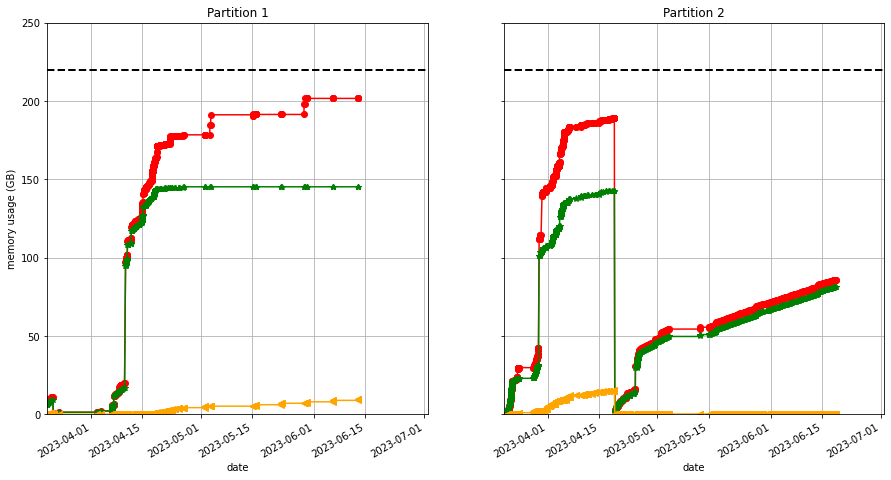

In [11]:
plot_tot(PHI,ylim=(0,250),time_ord=True,xlim=(datetime.datetime(2023,3,20),datetime.datetime(2023,7,2)))

In [105]:
out[2].__dict__

{'level': 'raw.crop.pack',
 'did': '0343220501',
 'cadence': 1,
 'start': datetime.datetime(2023, 3, 23, 18, 54, 20),
 'n_datasets': 2,
 'end': datetime.datetime(2023, 3, 23, 18, 57, 20),
 'n_bits': 16,
 'X': 1536,
 'Y': 1536,
 'P': 4,
 'L': 6,
 'n_pix': 75497472,
 'n_outputs': 24,
 'this_run': 2,
 'metadata': 16,
 'data': 240,
 'data_tot': 256,
 'not_datasets': 0,
 'interm_data_tot': 0,
 'time': datetime.timedelta(seconds=180),
 'cpu_time': datetime.timedelta(seconds=90),
 'compr': <TMclass.COMPR at 0x7f8d89fce2b0>}

In [94]:
datetime.datetime(2023,5,15) - datetime.datetime(2023,5,24)

datetime.timedelta(days=-9)

In [12]:
def simul_syn(cad = [4,4,4,4,4,4,4,4,4], bits = 6, outputs = 24, meta = 0.5):
    """
    1408: 04.26 - 05.01. 6d

    1280: 05.02 - 05.14. 13d

    1024: 05.15 - 05.23. 9d

    896: 05.24. - 06.15. 23d

    768: 06.16. - 08.05. 51d

    896: 08.06. - 08.25. 20d

    1024: 08:26. - 09.05. 11d

    1280: 09.06. - 09.17. 12d

    1408: 09.18. - 09.23. 6d (from 5 to 6, changed by DC to add the whole conjunction, TBC by JH)

    1536: 09.24. - 09.28. 5d (added by DC to add the whole conjunction, TBC by JH)

    """

    crop = [1408,1280,1024,896,768,896,1024,1280,1408,1536]
    duration = [6,13,9,23,51,20,11,12,6,5]

    cad = np.asarray(cad); crop = np.asarray(crop); duration = np.asarray(duration)
    telemetry = duration * cad * (outputs * crop**2 * bits /8e6 + meta)

    print(f"{crop[0]}: 04.26. - 05.01. {duration[0]}d: {cad[0]} datasets/day")
    print(f"{crop[1]}: 05.02. - 05.14. {duration[1]}d: {cad[1]} datasets/day")
    print(f"{crop[2]}: 05.15. - 05.23. {duration[2]}d: {cad[2]} datasets/day")
    print(f"{crop[3]}: 05.24. - 06.15. {duration[3]}d: {cad[3]} datasets/day")
    print(f"{crop[4]}: 06.16. - 08.05. {duration[4]}d: {cad[4]} datasets/day")
    print(f"{crop[5]}: 08.06. - 08.25. {duration[5]}d: {cad[5]} datasets/day")
    print(f"{crop[6]}: 08:26. - 09.05. {duration[6]}d: {cad[6]} datasets/day")
    print(f"{crop[7]}: 09.06. - 09.17. {duration[7]}d: {cad[7]} datasets/day")
    print(f"{crop[8]}: 09.18. - 09.23. {duration[8]}d: {cad[8]} datasets/day")
    print(f"{crop[9]}: 09.24. - 09.28. {duration[9]}d: {cad[9]} datasets/day")

    print('telemetry for each cropping run:',np.round(telemetry,1),'MB')
    print('total telemetry:',np.round(telemetry.sum(),1),'MB')
    # return telemetry


simul_syn([2,2,2,4,4,4,4,4,4,4])

1408: 04.26. - 05.01. 6d: 2 datasets/day
1280: 05.02. - 05.14. 13d: 2 datasets/day
1024: 05.15. - 05.23. 9d: 2 datasets/day
896: 05.24. - 06.15. 23d: 4 datasets/day
768: 06.16. - 08.05. 51d: 4 datasets/day
896: 08.06. - 08.25. 20d: 4 datasets/day
1024: 08:26. - 09.05. 11d: 4 datasets/day
1280: 09.06. - 09.17. 12d: 4 datasets/day
1408: 09.18. - 09.23. 6d: 4 datasets/day
1536: 09.24. - 09.28. 5d: 4 datasets/day
telemetry for each cropping run: [ 434.2  779.8  348.7 1375.5 2267.8 1196.1  852.5 1439.6  868.4  859.3] MB
total telemetry: 10421.9 MB


In [106]:
out[2].X*out[2].Y*out[2].P*out[2].L*6/8/2**20 + 0.01 #out[2].compr.metadata/out[2].compr.this_run*1e6/2**20


40.51

In [20]:
obs['0303220101'].raw.pack.compr.data/obs['0303220101'].raw.pack.compr.this_run
obs['0303220101'].raw.pack.compr.__dict__

{'level': 'raw.pack.compr',
 'did': '0343220101',
 'cadence': 1,
 'start': datetime.datetime(2023, 3, 28, 0, 8),
 'n_datasets': 21,
 'end': datetime.datetime(2023, 3, 28, 2, 8, 48, 621312),
 'n_bits': 6,
 'X': 2048,
 'Y': 2048,
 'P': 4,
 'L': 6,
 'n_pix': 100663296,
 'n_outputs': 24,
 'this_run': 12,
 'metadata': 0.10799999999999998,
 'data': 905.969664,
 'data_tot': 1585.635912,
 'not_datasets': 4,
 'interm_data_tot': 0,
 'time': datetime.timedelta(seconds=12685, microseconds=87296),
 'cpu_time': datetime.timedelta(seconds=7248, microseconds=621312)}

In [129]:
# df.iloc[18802]
# obs['0303220001'].raw.crop.pack.start
# levels_did_out(obs['0323211500'])

In [134]:
PHI.part1.occu

195968.0

In [36]:
obs['0302090001'].raw.X

2048

In [46]:
df.iloc[13429]
# obs['0203240250']
# obs['025104001']
# find_did(obs,'0251040501')

start    2022-12-15 02:22:24
end      2022-12-15 02:28:24
fcp                  FCP-709
FP_1              0232150111
FP_2                       4
FP_3                       1
FP_4                        
FP_5                        
FP_6                        
FP_7                        
FP_8                        
FP_9                        
FP_10                       
FP_11                       
FP_12                       
FP_13                       
FP_14                       
FP_15                       
FP_16                       
FP_17                       
FP_18                       
FP_19                       
FP_20                       
FP_21                       
FP_22                       
FP_23                       
FP_24                       
FP_25                       
FP_26                       
FP_27                       
FP_28                       
FP_29                       
FP_30                       
FP_31                       
FP_32         

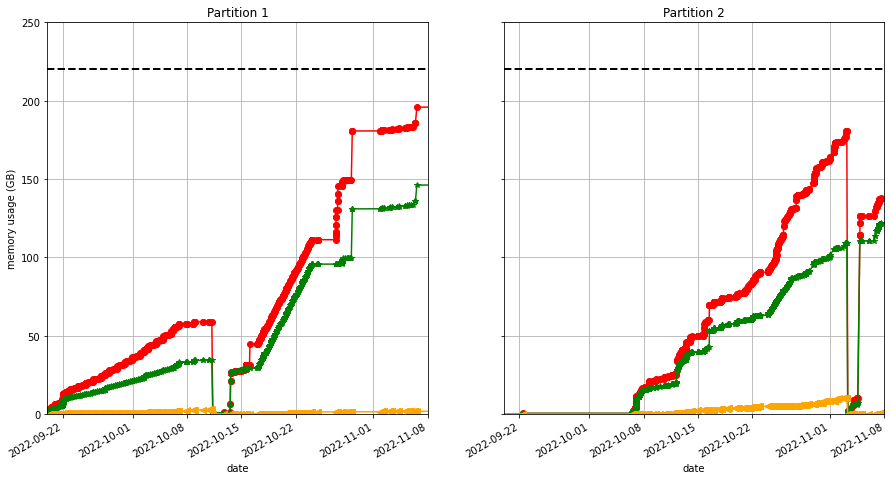

In [6]:
plot_tot(PHI,ylim=(0,250),xlim=(datetime.datetime(2022,9,20),datetime.datetime(2022,11,8)))

In [17]:
np.where(np.asarray(PHI.part1.history['raw'])<0,)
PHI.part2.history['start'][-1]
# PHI.part1.history['start'][1054]
# PHI.part2.history['start'][-1]
# PHI.part1.history['start'][-1]

datetime.datetime(2022, 9, 22, 10, 37, 10)

In [28]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# idx1 = find_nearest(PHI.part1.history['start'],datetime.datetime(2022, 4, 8, 0, 0))
# idx2 = find_nearest(PHI.part2.history['start'],datetime.datetime(2022, 4, 8, 0, 0))
# print((PHI.part1.compr+PHI.part2.compr)*1e6/2**20)

# idx1 = find_nearest(PHI.part1.history['start'],datetime.datetime(2022, 4, 8, 0, 0))
df.query('start == "2022-10-12 22:49:42"')

,start,end,fcp,FP_1,FP_2,FP_3,FP_4,FP_5,FP_6,FP_7,...,FP_26,FP_27,FP_28,FP_29,FP_30,FP_31,FP_32,FP_33,FP_34,FP_35
10467,2022-10-12 22:49:42,2022-10-12 22:51:42,FCP-704,0210120403,,,,,,,...,,,,,,,,,,


In [56]:
a = obs['0210120001']
hasattr(a,'raw')
import inspect
for i in inspect.getmembers(a.raw):
     
    # to remove private and protected
    # functions
    if not i[0].startswith('_'):

        
        # To remove other methods that
        # doesnot start with a underscore
        if not inspect.ismethod(i[1]):
            print(i)

('L', 6)
('P', 4)
('X', 2048)
('Y', 2048)
('cadence', 1.6666666666666667)
('crop', <TMclass.CROP object at 0x7f198556d5b0>)
('data', 408)
('data_tot', 1248)
('end', datetime.datetime(2022, 10, 12, 22, 31, 40))
('metadata', 8)
('n_bits', 32)
('n_datasets', 3)
('n_outputs', 24)
('n_pix', 100663296)
('pack', <TMclass.PACK object at 0x7f198556d1f0>)
('start', datetime.datetime(2022, 10, 12, 22, 30))
('this_run', 1)


(19297.0, 19324.0)

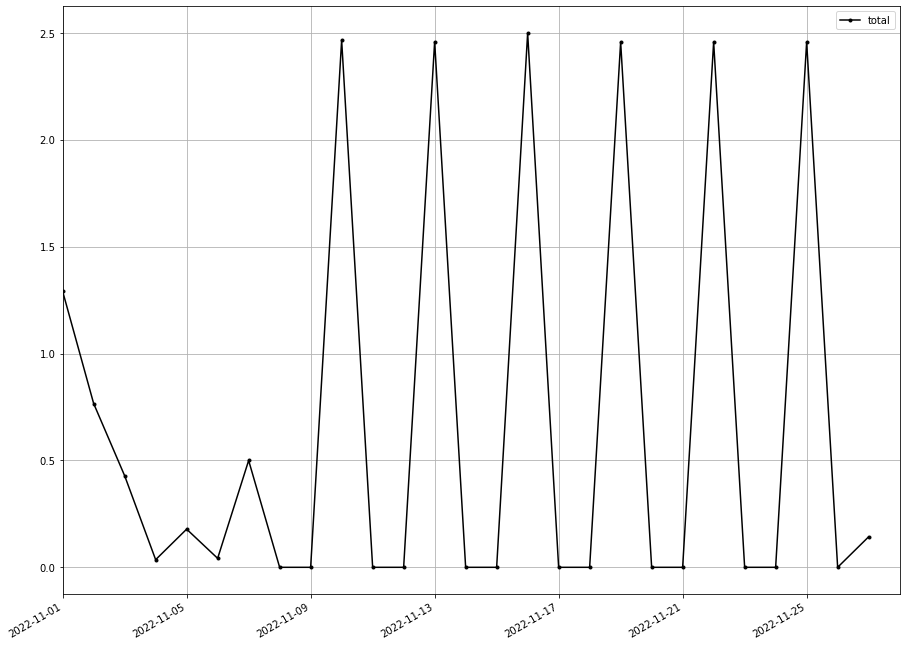

In [7]:
temp = PHI.part1.history    # plt.subplot(121)
c1 = np.asarray(PHI.part1.history['compr'])
c2 = np.asarray(PHI.part2.history['compr'])

d1 = np.asarray(PHI.part1.history['start'])
d2 = np.asarray(PHI.part2.history['start'])

starttime = min(d1[0],d2[0])
endtime = max(d1[-1],d2[-1])
t0 = starttime
times = []
while starttime.date() <= endtime.date():
    times.append(starttime.date())
    starttime += datetime.timedelta(days=1)
starttime = t0; del t0
times_float = [(t - d1[0]).total_seconds() for t in d1]
times = np.asarray(times)

newc1 = np.zeros(np.size(times))
for i,j in zip(d1,c1):
    if j>=0:
        ind = np.where(times == i.date())[0]
        newc1[ind] += j/1e3
newc1 = np.asarray(newc1)

newc2 = np.zeros(np.size(times))
for i,j in zip(d2,c2):
    if j>=0:
        ind = np.where(times == i.date())[0]
        newc2[ind] += j/1e3
newc2 = np.asarray(newc2)


plt.figure(figsize=(15,12))
# plt.plot_date(times,newc1,color='blue',linestyle='-',marker='.',label='partition 1')
# plt.plot_date(times,newc2,color='red',linestyle='-',marker='.',label='partition 2')
plt.plot_date(times,newc1+newc2,color='black',linestyle='-',marker='.',label='total')
plt.gcf().autofmt_xdate()
plt.grid()
plt.legend()
plt.xlim(datetime.datetime(2022,11,1),datetime.datetime(2022,11,28))
